In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import os
import ast

In [2]:
df = pd.read_csv("CleanData.csv", parse_dates=True)
df.columns = df.columns.str.replace(" Name", "", regex=False)
df

,Category,Longitude,Latitude,Width,Length,Land Type,Area,House Direction,Property Features,Floors,Rooms,Toilets,Furnishing Sell,Price
0,Đất,108.158270,16.053888,5.0,23.00000,3,102.0000,8.0,['1 Part Residential'],0.0,0.0,0.0,0.0,165000000
1,Đất,108.172516,16.028736,5.0,20.00000,3,100.0000,6.0,"['No Residential', 'Back Expansion', '1 Part R...",0.0,0.0,0.0,0.0,250000000
2,Đất,108.136940,16.077059,5.0,20.00000,3,100.0000,4.0,"['No Residential', 'Back Expansion']",0.0,0.0,0.0,0.0,250000000
3,Đất,108.150030,16.066383,5.0,15.00000,3,75.0000,4.0,['No Residential'],0.0,0.0,0.0,0.0,280000000
4,Đất,108.172516,15.972230,5.0,30.00000,1,153.0000,5.0,"['Frontage', '1 Part Residential']",0.0,0.0,0.0,0.0,415000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14544,Nhà ở,108.246650,16.070292,5.0,19.00000,0,95.0000,4.0,['No thing'],2.0,3.0,2.0,2.0,10200000000
14545,Nhà ở,108.217340,16.044945,5.0,16.60000,0,83.0000,7.0,['No thing'],2.0,3.0,2.0,3.0,10500000000
14546,Nhà ở,108.214355,16.035374,5.0,19.00000,0,98.0000,2.0,['No thing'],3.0,3.0,4.0,2.0,11500000000
14547,Nhà ở,108.222230,16.051630,5.0,12.00000,0,60.0000,1.0,['No thing'],4.0,5.0,5.0,1.0,13500000000


In [3]:
def convert_to_list(value):
    if isinstance(value, str): 
        try:
            return ast.literal_eval(value)  
        except:
            return [value.strip()]  
    elif isinstance(value, list):
        return value 
    else:
        return [] 

### One-hot encoding 

In [4]:
category_mapping = {
  'Nhà ở': 'HOUSE',
  'Đất': 'LAND'
}

land_type_mapping = {
    0: 'RESIDENTIAL_LAND',
    1: 'PROJECT_LAND',
    2: 'INDUSTRIAL_LAND',
    3: 'AGRICULTURAL_LAND'
}

house_direction_mapping = {
    1: 'NORTH',       # Bắc
    2: 'SOUTH',       # Nam
    3: 'EAST',        # Đông
    4: 'WEST',        # Tây
    5: 'NORTHEAST',   # Đông Bắc
    6: 'SOUTHEAST',   # Đông Nam
    7: 'NORTHWEST',   # Tây Bắc
    8: 'SOUTHWEST'    # Tây Nam
}

furnishing_sell_mapping = {
    0: 'HIGH_END_FURNITURE',
    1: 'FULLY_FURNISHED',
    2: 'BASIC_FINISHING',
    3: 'RAW_HANDOVER'
}
df['House Direction'] = df['House Direction'].astype(float).astype('Int64')
df['Furnishing Sell'] = df['Furnishing Sell'].astype(float).astype('Int64')
df['Land Type'] = df['Land Type'].astype(float).astype('Int64')
df['House Direction'] = df['House Direction'].map(house_direction_mapping)
df['Land Type'] = df['Land Type'].map(land_type_mapping)
df['Category'] = df['Category'].map(category_mapping)
df['Furnishing Sell'] = df['Furnishing Sell'].map(furnishing_sell_mapping)
df.head()

,Category,Longitude,Latitude,Width,Length,Land Type,Area,House Direction,Property Features,Floors,Rooms,Toilets,Furnishing Sell,Price
0,LAND,108.158270,16.053888,5.0,23.0,AGRICULTURAL_LAND,102.0,SOUTHWEST,['1 Part Residential'],0.0,0.0,0.0,HIGH_END_FURNITURE,165000000
1,LAND,108.172516,16.028736,5.0,20.0,AGRICULTURAL_LAND,100.0,SOUTHEAST,"['No Residential', 'Back Expansion', '1 Part R...",0.0,0.0,0.0,HIGH_END_FURNITURE,250000000
2,LAND,108.136940,16.077059,5.0,20.0,AGRICULTURAL_LAND,100.0,WEST,"['No Residential', 'Back Expansion']",0.0,0.0,0.0,HIGH_END_FURNITURE,250000000
3,LAND,108.150030,16.066383,5.0,15.0,AGRICULTURAL_LAND,75.0,WEST,['No Residential'],0.0,0.0,0.0,HIGH_END_FURNITURE,280000000
4,LAND,108.172516,15.972230,5.0,30.0,PROJECT_LAND,153.0,NORTHEAST,"['Frontage', '1 Part Residential']",0.0,0.0,0.0,HIGH_END_FURNITURE,415000000


In [5]:
df["Property Features"] = df["Property Features"].apply(convert_to_list)
mlb = MultiLabelBinarizer()

features_encoded = mlb.fit_transform(df["Property Features"])
df_features = pd.DataFrame(features_encoded, columns=mlb.classes_)

df = df.drop(columns=["Property Features"]).reset_index(drop=True)
# df_final = df_final.drop(columns=["Property Features"]).reset_index(drop=True)
df = pd.concat([df, df_features], axis=1)
df = df.drop(columns=["No thing"]).reset_index(drop=True)

df.head()

,Category,Longitude,Latitude,Width,Length,Land Type,Area,House Direction,Floors,Rooms,Toilets,Furnishing Sell,Price,1 Part Residential,All Residential,Back Expansion,Car Alley,Frontage,No Residential
0,LAND,108.158270,16.053888,5.0,23.0,AGRICULTURAL_LAND,102.0,SOUTHWEST,0.0,0.0,0.0,HIGH_END_FURNITURE,165000000,1,0,0,0,0,0
1,LAND,108.172516,16.028736,5.0,20.0,AGRICULTURAL_LAND,100.0,SOUTHEAST,0.0,0.0,0.0,HIGH_END_FURNITURE,250000000,1,0,1,0,0,1
2,LAND,108.136940,16.077059,5.0,20.0,AGRICULTURAL_LAND,100.0,WEST,0.0,0.0,0.0,HIGH_END_FURNITURE,250000000,0,0,1,0,0,1
3,LAND,108.150030,16.066383,5.0,15.0,AGRICULTURAL_LAND,75.0,WEST,0.0,0.0,0.0,HIGH_END_FURNITURE,280000000,0,0,0,0,0,1
4,LAND,108.172516,15.972230,5.0,30.0,PROJECT_LAND,153.0,NORTHEAST,0.0,0.0,0.0,HIGH_END_FURNITURE,415000000,1,0,0,0,1,0


In [6]:
# Các cột cần áp dụng one-hot encoding
categorical_columns = ['Category', 'Land Type', 'House Direction', 'Furnishing Sell']

# Tạo và áp dụng OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_columns])

# Lấy tên các cột mới sau khi encoding
encoded_feature_names = []
for i, feature in enumerate(categorical_columns):
    categories = encoder.categories_[i]
    for category in categories:
        encoded_feature_names.append(f"{feature}_{category}")

# Tạo DataFrame mới với dữ liệu đã được mã hóa
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names, index=df.index)

# Kết hợp với các cột không phải dạng phân loại từ DataFrame gốc
# Lấy tất cả các cột không thuộc categorical_columns
non_categorical_columns = [col for col in df.columns if col not in categorical_columns]
result_df = pd.concat([df[non_categorical_columns], encoded_df], axis=1)

# Hiển thị kết quả
print(f"Shape ban đầu: {df.shape}")
print(f"Shape sau khi one-hot encoding: {result_df.shape}")
print(f"Các cột mới được tạo: {len(encoded_feature_names)}")
df = result_df.copy()
df

Shape ban đầu: (14549, 19)
Shape sau khi one-hot encoding: (14549, 33)
Các cột mới được tạo: 18


,Longitude,Latitude,Width,Length,Area,Floors,Rooms,Toilets,Price,1 Part Residential,...,House Direction_NORTHEAST,House Direction_NORTHWEST,House Direction_SOUTH,House Direction_SOUTHEAST,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER
0,108.158270,16.053888,5.0,23.00000,102.0000,0.0,0.0,0.0,165000000,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,108.172516,16.028736,5.0,20.00000,100.0000,0.0,0.0,0.0,250000000,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,108.136940,16.077059,5.0,20.00000,100.0000,0.0,0.0,0.0,250000000,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,108.150030,16.066383,5.0,15.00000,75.0000,0.0,0.0,0.0,280000000,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,108.172516,15.972230,5.0,30.00000,153.0000,0.0,0.0,0.0,415000000,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14544,108.246650,16.070292,5.0,19.00000,95.0000,2.0,3.0,2.0,10200000000,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
14545,108.217340,16.044945,5.0,16.60000,83.0000,2.0,3.0,2.0,10500000000,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14546,108.214355,16.035374,5.0,19.00000,98.0000,3.0,3.0,4.0,11500000000,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14547,108.222230,16.051630,5.0,12.00000,60.0000,4.0,5.0,5.0,13500000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Feature Transformation

### Normalize using Arcsine method

In [7]:
columns_to_asinh = ["Price", "Longitude", "Latitude", "Area", "Width", "Length", "Floors", "Rooms", "Toilets"]
df_asinh_transformed = df.copy()
df_asinh_transformed[columns_to_asinh] = np.arcsinh(df_asinh_transformed[columns_to_asinh])
df_asinh_transformed[columns_to_asinh].head()

,Price,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets
0,19.614603,5.376764,3.470067,5.318144,2.312438,3.829114,0.0,0.0,0.0
1,20.030119,5.376896,3.468502,5.298342,2.312438,3.689504,0.0,0.0,0.0
2,20.030119,5.376567,3.471506,5.298342,2.312438,3.689504,0.0,0.0,0.0
3,20.143447,5.376688,3.470843,5.010680,2.312438,3.402307,0.0,0.0,0.0
4,20.536936,5.376896,3.464977,5.723596,2.312438,4.094622,0.0,0.0,0.0


### Normalization using Z-score method

In [8]:
columns_to_zScore = ["Price", "Longitude", "Latitude", "Area", "Width", "Length", "Floors", "Rooms", "Toilets"]
std_scaler_zScore = StandardScaler()
df_std_scaled_zScore = std_scaler_zScore.fit_transform(df[columns_to_zScore])
df_std_scaled_zScore = pd.DataFrame(df_std_scaled_zScore, columns=columns_to_zScore)
df_std_scaled_zScore[columns_to_zScore].head()

,Price,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets
0,-1.952213,-1.299306,0.469300,0.425953,0.0,1.019066,-0.811617,-0.794199,-0.776965
1,-1.913715,-0.917810,-0.200249,0.335440,0.0,0.337356,-0.811617,-0.794199,-0.776965
2,-1.913715,-1.870506,1.086114,0.335440,0.0,0.337356,-0.811617,-0.794199,-0.776965
3,-1.900128,-1.519967,0.801918,-0.795977,0.0,-0.798828,-0.811617,-0.794199,-0.776965
4,-1.838984,-0.917810,-1.704444,2.734042,0.0,2.609723,-0.811617,-0.794199,-0.776965


### Normalize using Logarithmic method

In [9]:
columns_to_log = ["Price", "Longitude", "Latitude", "Area", "Width", "Length", "Floors", "Rooms", "Toilets"]
df_log_transformed = df.copy()
df_log_transformed = df[columns_to_log].apply(np.log1p)
df_log_transformed = pd.DataFrame(df_log_transformed, columns=columns_to_log)
df_log_transformed[columns_to_log].head()

,Price,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets
0,18.921456,4.692799,2.836378,4.634729,1.791759,3.178054,0.0,0.0,0.0
1,19.336971,4.692929,2.834902,4.615121,1.791759,3.044522,0.0,0.0,0.0
2,19.336971,4.692603,2.837736,4.615121,1.791759,3.044522,0.0,0.0,0.0
3,19.450300,4.692723,2.837111,4.330733,1.791759,2.772589,0.0,0.0,0.0
4,19.843789,4.692929,2.831578,5.036953,1.791759,3.433987,0.0,0.0,0.0


### Normalize using square root method

In [10]:
columns_to_sqrt = ["Price", "Longitude", "Latitude", "Area", "Width", "Length", "Floors", "Rooms", "Toilets"]
df_sqrt_transformed = df.copy()
df_sqrt_transformed = df[columns_to_sqrt].apply(np.sqrt)
df_sqrt_transformed = pd.DataFrame(df_sqrt_transformed, columns=columns_to_sqrt)
df_sqrt_transformed[columns_to_sqrt].head()

,Price,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets
0,12845.232579,10.399917,4.006730,10.099505,2.236068,4.795832,0.0,0.0,0.0
1,15811.388301,10.400602,4.003590,10.000000,2.236068,4.472136,0.0,0.0,0.0
2,15811.388301,10.398891,4.009621,10.000000,2.236068,4.472136,0.0,0.0,0.0
3,16733.200531,10.399521,4.008289,8.660254,2.236068,3.872983,0.0,0.0,0.0
4,20371.548787,10.400602,3.996527,12.369317,2.236068,5.477226,0.0,0.0,0.0


### Data verification

*Histogram comparing the variable Price before and after normalization*

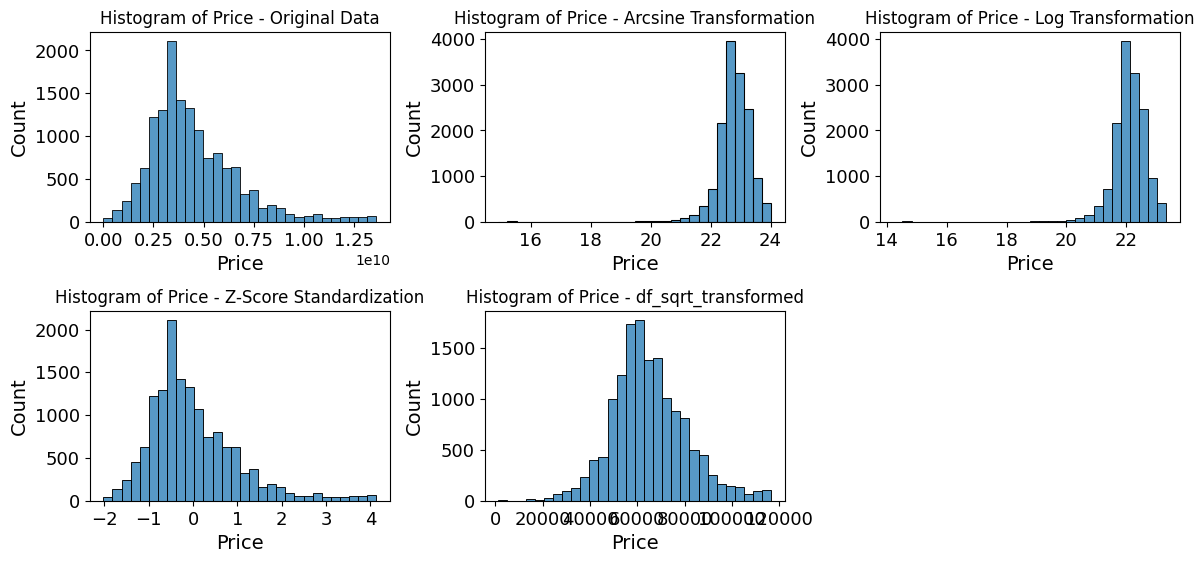

In [11]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Price'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Price', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Price - {method}')
    plt.tight_layout()

plt.show()

*Histogram comparing the variable Area before and after normalization*

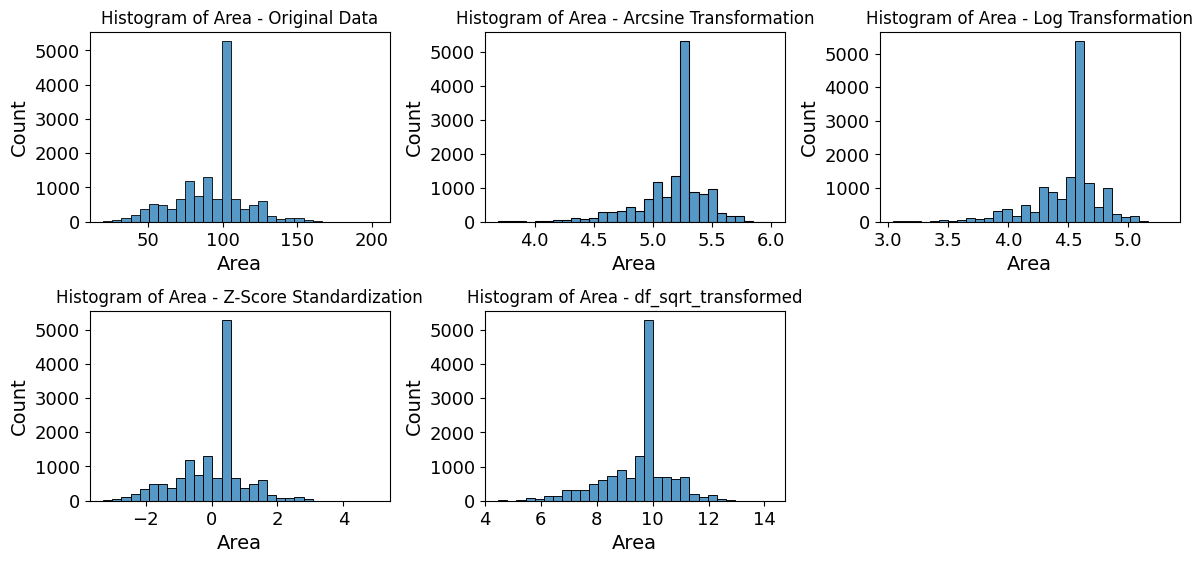

In [12]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Area'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Area', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Area - {method}')
    plt.tight_layout()

plt.show()

*Use probability graph to verify whether the transformed data follows the normal distribution*

- Comparison of the distribution of the *Price* feature when applying normalization methods

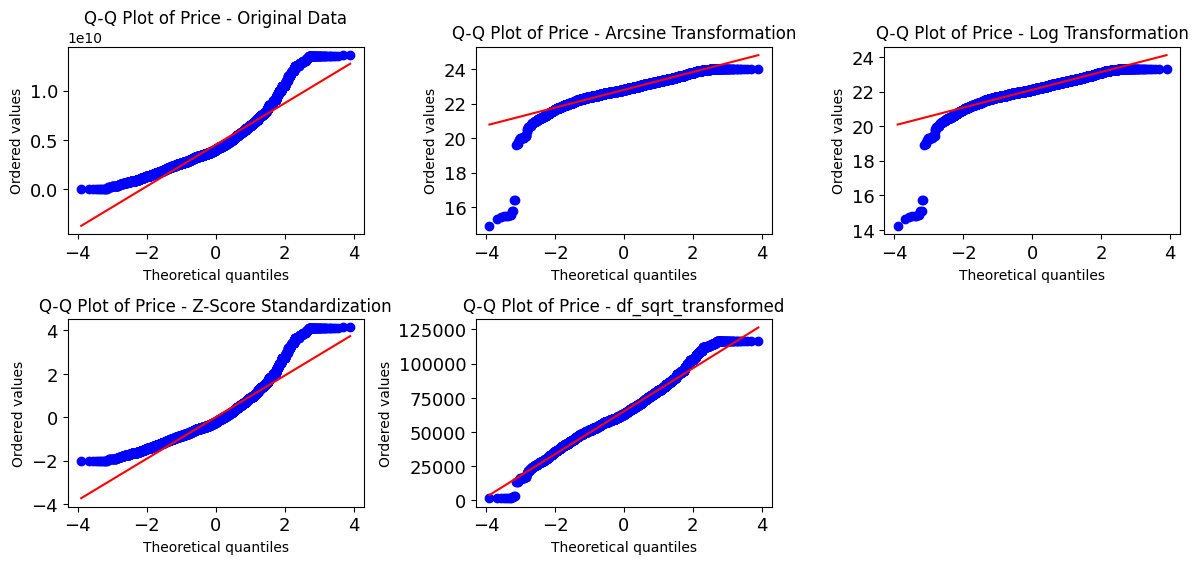

In [13]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Price'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Price - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Area* feature when applying normalization methods

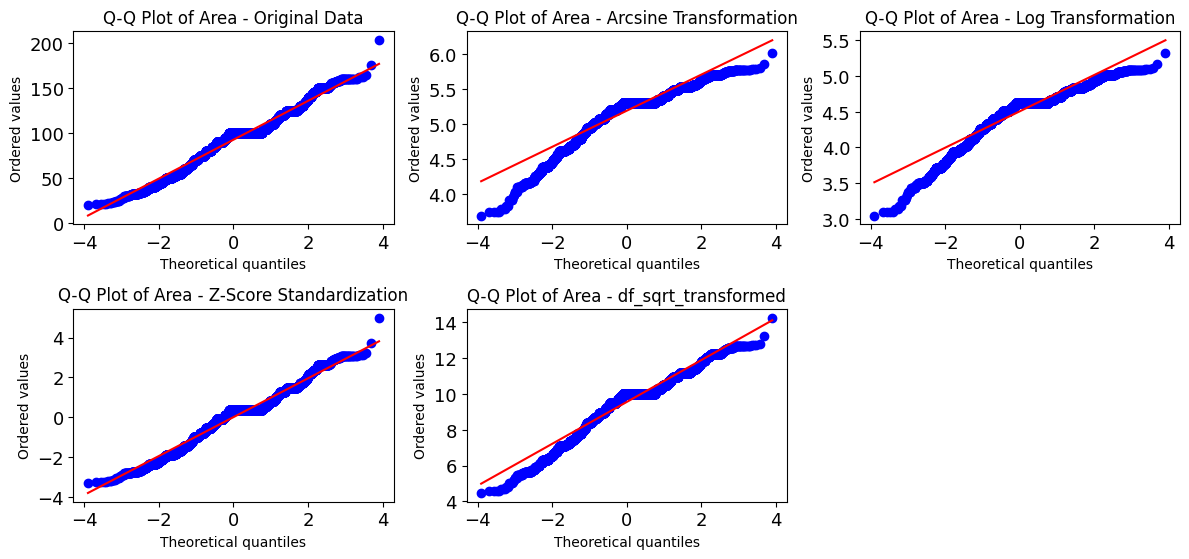

In [14]:
dfs = [df,df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Area'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Area - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Width* feature when applying normalization methods

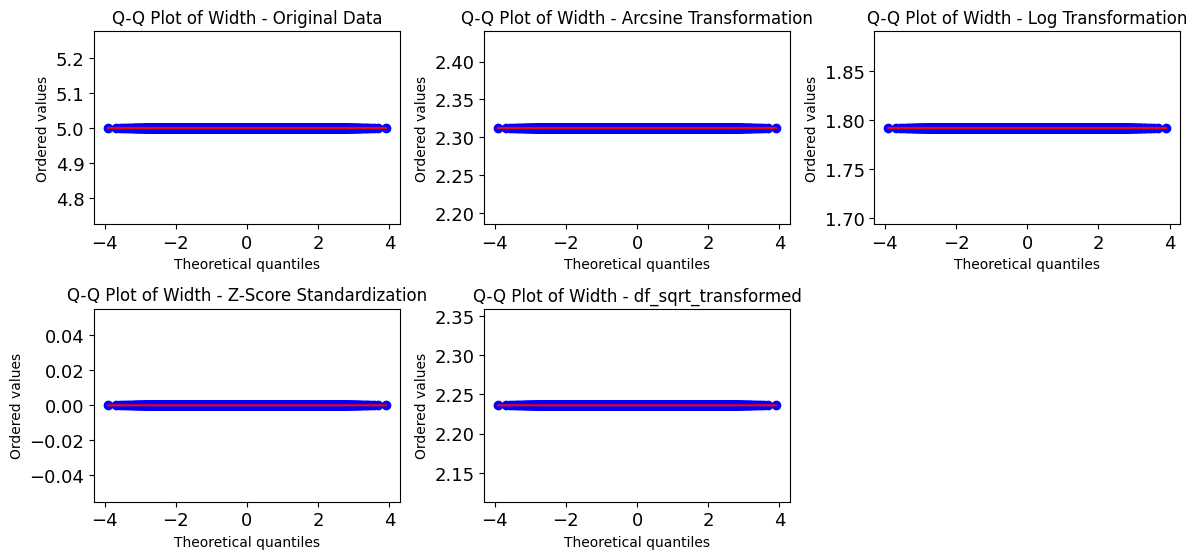

In [15]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Width'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Width - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Longitude* feature when applying normalization methods

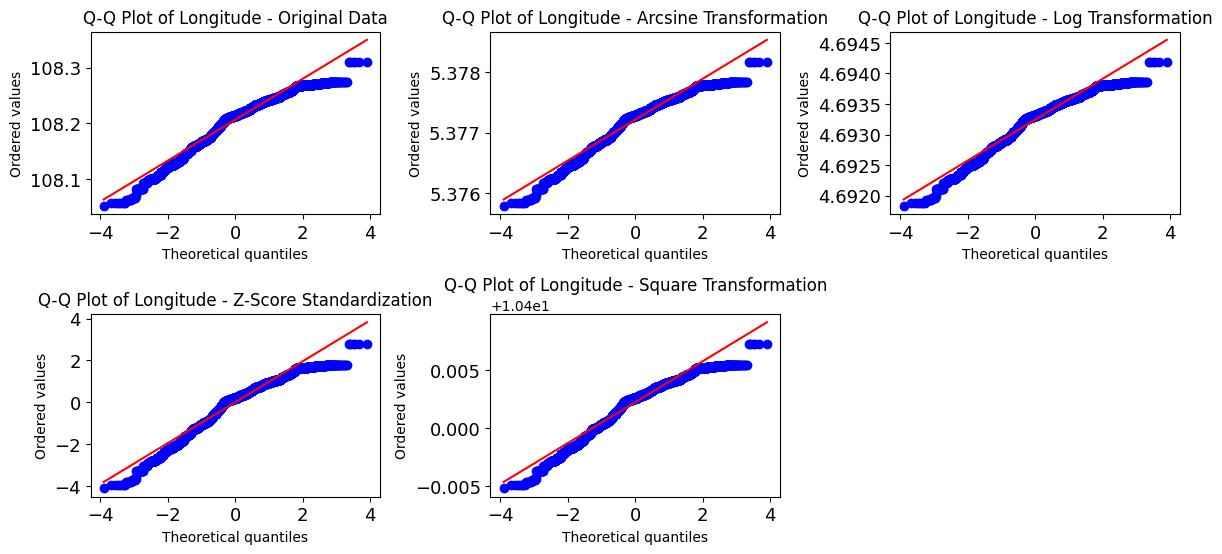

In [16]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Longitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Longitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Latitude* feature when applying normalization methods

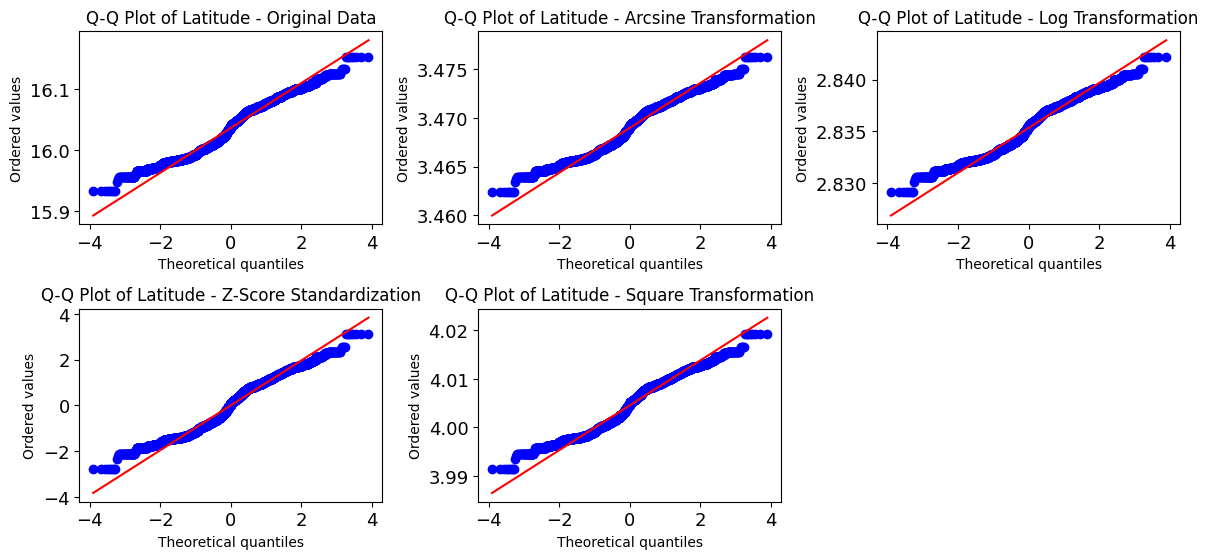

In [17]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Latitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Latitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Floors* when applying standardized methods

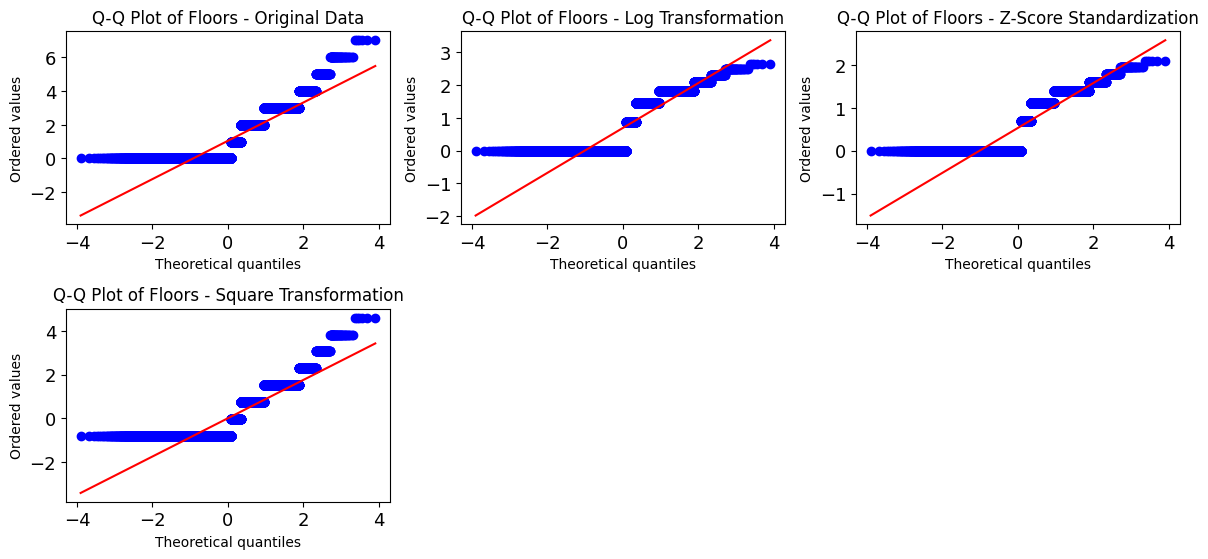

In [18]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Floors"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Floors - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Rooms* when applying standardized methods

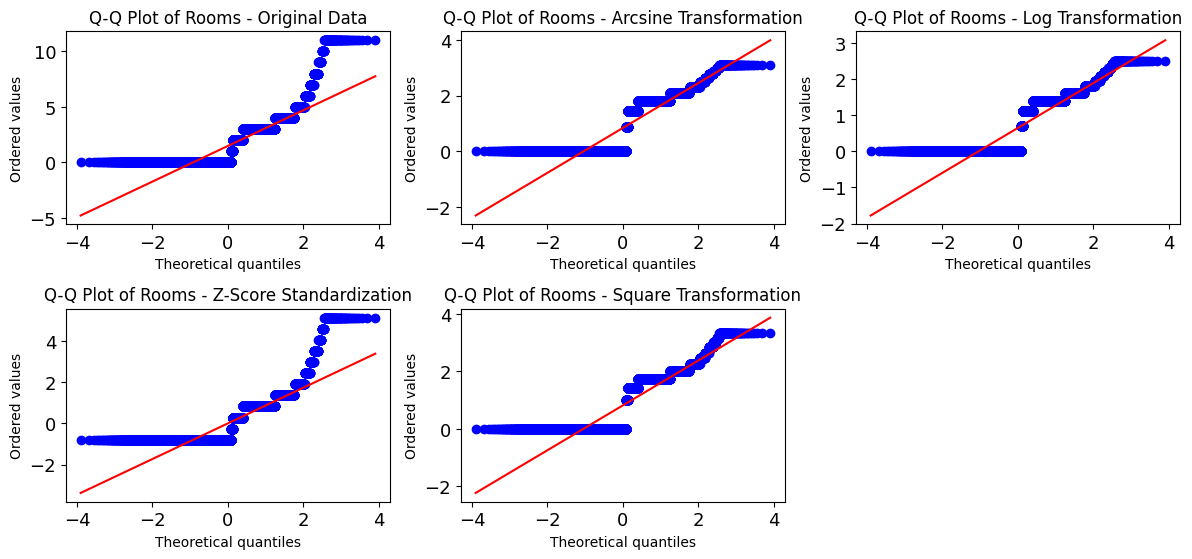

In [19]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data",'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Rooms"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Rooms - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Toilets* when applying standardized methods

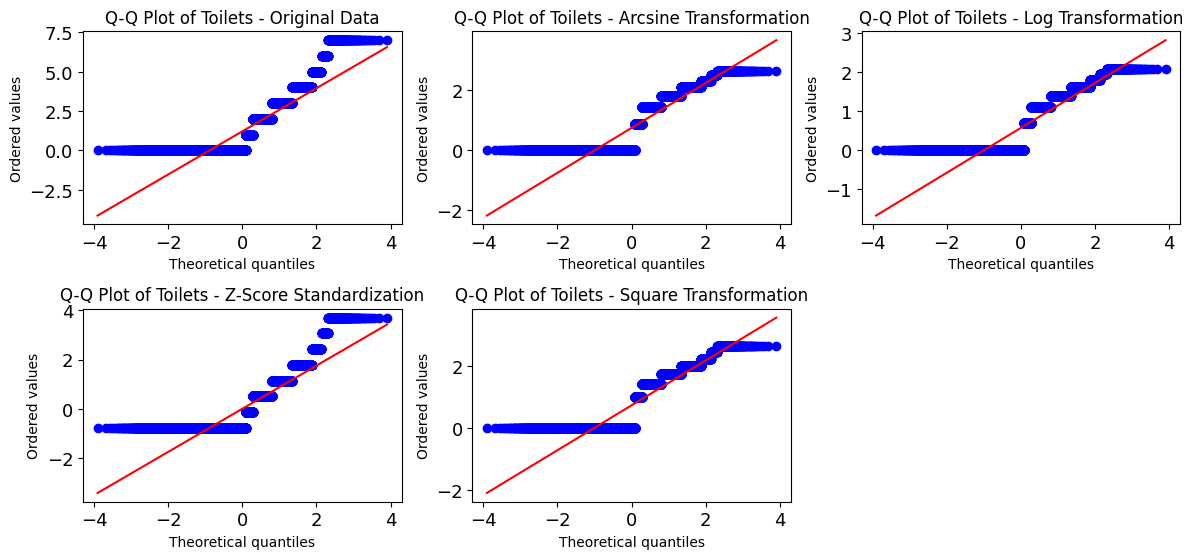

In [20]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Toilets"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Toilets - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

*The characteristic that follows the most normal distribution is standardized by the square root method.*

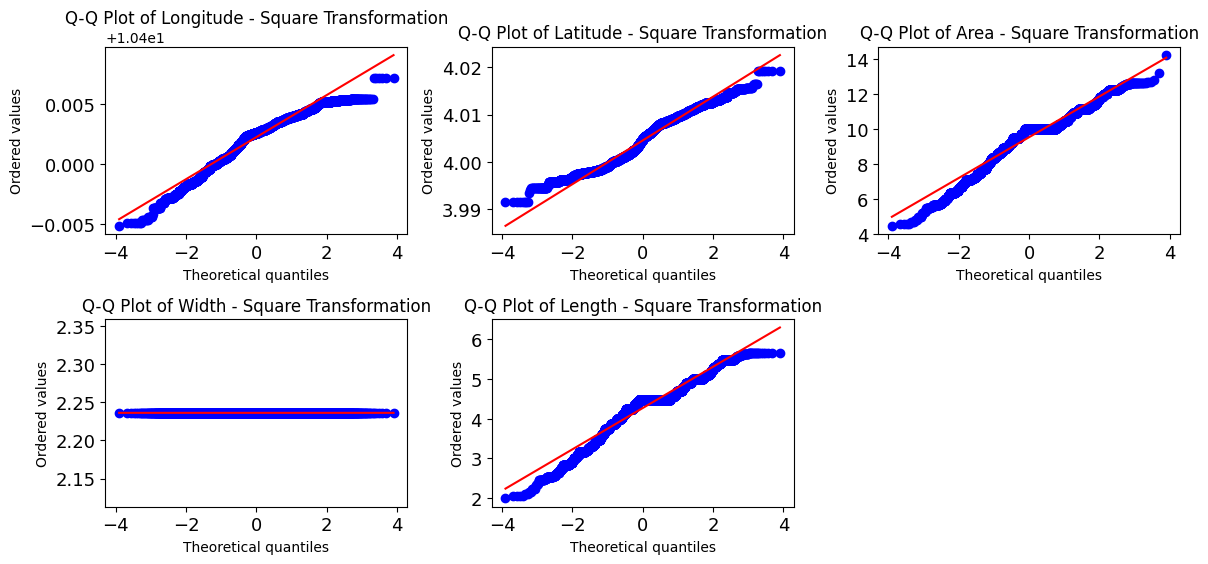

In [21]:
cols = ["Longitude", "Latitude", "Area", "Width", "Length"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_sqrt_transformed[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col} - Square Transformation")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Length* when applying standardized methods

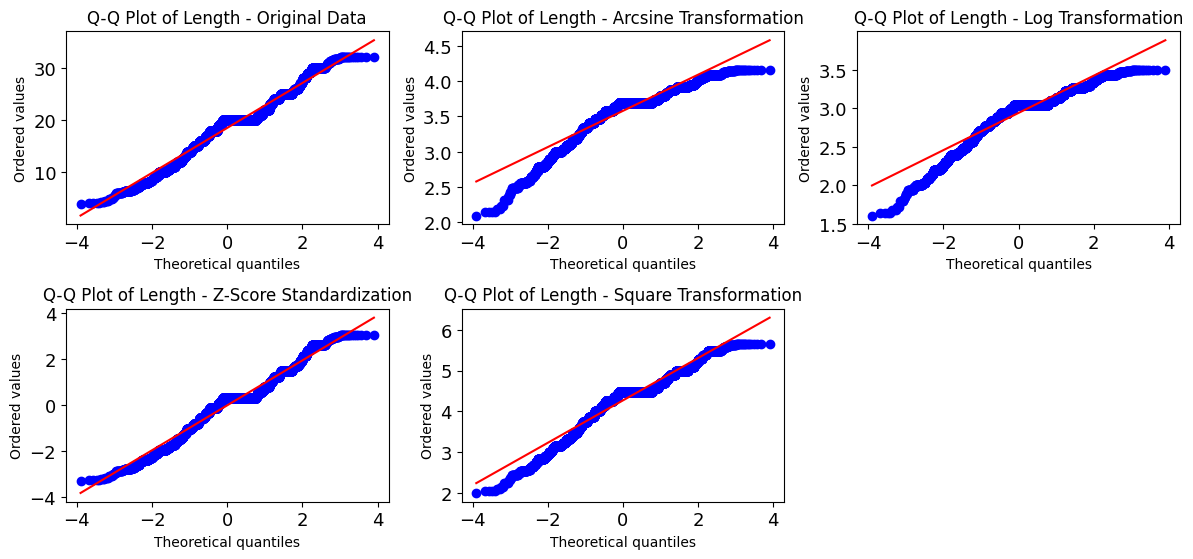

In [22]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Length"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Length - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

=> Select Z-Score normalization method for feature *Length* & *Price* and Square root method for features *Longitude, Latitude, Area, Width, Floors, Rooms, Toilets*

In [23]:
df_final = df.copy()

df_final["Length"] = df_std_scaled_zScore["Length"]
df_final["Price"] = df_std_scaled_zScore["Price"]
columns_sqrt = ["Longitude", "Latitude", "Area", "Width", "Floors", "Rooms", "Toilets"]
df_final[columns_sqrt] = df_sqrt_transformed[columns_sqrt]

df_final.head()


,Longitude,Latitude,Width,Length,Area,Floors,Rooms,Toilets,Price,1 Part Residential,...,House Direction_NORTHEAST,House Direction_NORTHWEST,House Direction_SOUTH,House Direction_SOUTHEAST,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER
0,10.399917,4.006730,2.236068,1.019066,10.099505,0.0,0.0,0.0,-1.952213,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,10.400602,4.003590,2.236068,0.337356,10.000000,0.0,0.0,0.0,-1.913715,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10.398891,4.009621,2.236068,0.337356,10.000000,0.0,0.0,0.0,-1.913715,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10.399521,4.008289,2.236068,-0.798828,8.660254,0.0,0.0,0.0,-1.900128,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,10.400602,3.996527,2.236068,2.609723,12.369317,0.0,0.0,0.0,-1.838984,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


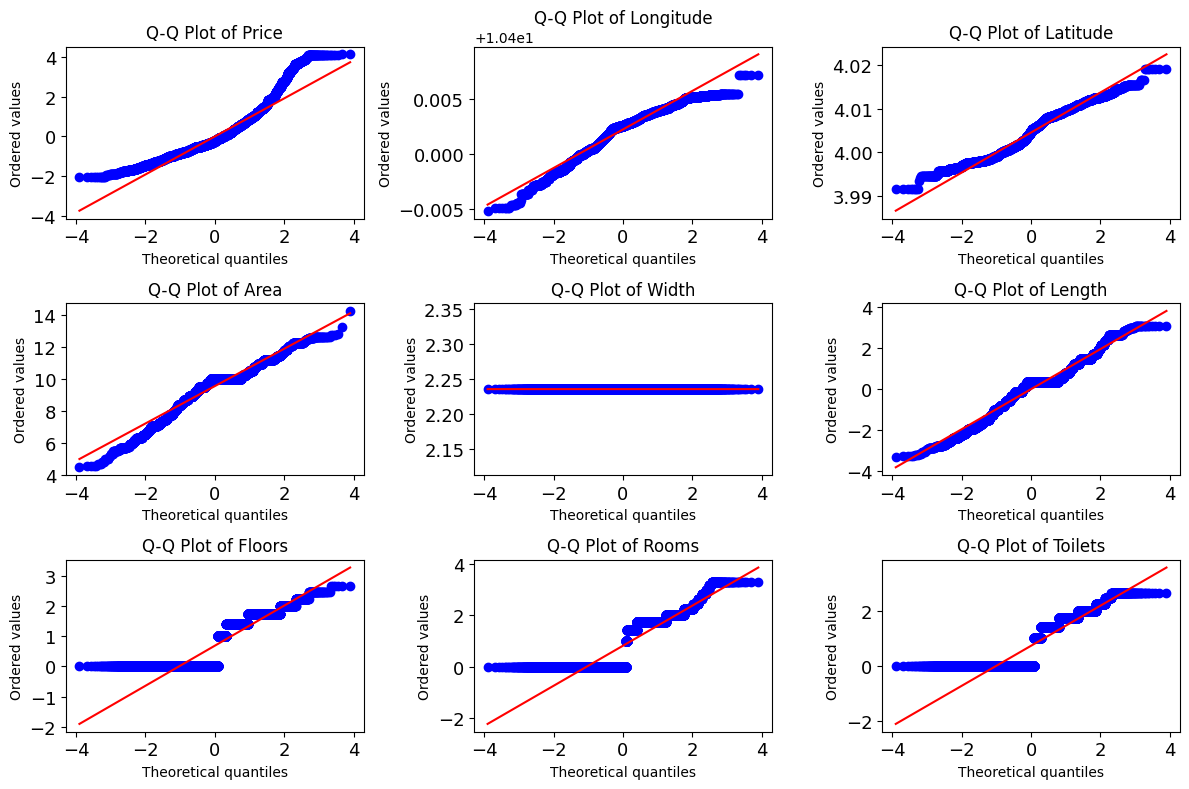

In [24]:
cols = ["Price", "Longitude", "Latitude", "Area", "Width", "Length", "Floors", "Rooms", "Toilets"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_final[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

In [25]:
# Get mean and std from scaler
means = std_scaler_zScore.mean_
stds = std_scaler_zScore.scale_

# Create DataFrame for statistics
stats = {
    'Metric': ['mean', 'std'],
    'price': [means[0], stds[0]],  # Assuming Price is the second column
    'length': [means[5], stds[5]]  # Assuming Length is the first column
}
# Thư mục mới để lưu file
output_dir = '../../Backend/src/main/resources/'

# Tạo thư mục nếu chưa tồn tại
os.makedirs(output_dir, exist_ok=True)

df_stats = pd.DataFrame(stats)

df_stats.to_csv('scaler_params.csv', index=False)
# Lưu file vào thư mục mới
output_path = os.path.join(output_dir, 'scaler_params.csv')
df_stats.to_csv(output_path, index=False)

print(f"File '{output_path}' has been successfully created!")
print("File 'scaler_params.csv' has been successfully created!")

File '../../Backend/src/main/resources/scaler_params.csv' has been successfully created!
File 'scaler_params.csv' has been successfully created!


In [26]:
df_final.to_csv('TransformedData.csv', index=False)
print("DataFrame exported to CSV file.")

DataFrame exported to CSV file.
